# Interfacing PowerModels.jl with pandapower

pandapower now has an interface to PowerModels.jl that can be used for efficient power system optimization.

### What is PowerModels.jl and why should I use it?

- [PowerModels.jl](https://lanl-ansi.github.io/PowerModels.jl/stable/) is  package for steady-state power network optimization
- It is based on the relatively new language [Julia](https://julialang.org/) which is gaining popularity in scientific applications
- PowerModels uses Julia/JuMP for the optimization, which [clearly outperforms the Python alternative Pyomo](http://yetanothermathprogrammingconsultant.blogspot.com/2015/05/model-generation-in-julia.html)
- PowerModels has a modular design that allows you to define [different formulations for optimization problems](https://lanl-ansi.github.io/PowerModels.jl/stable/specifications/)

### Well then why do I still need pandapower?

Because pandapower:

- allows you to easily define power systems with nameplate parameters and standard types
- comes with thouroughly validated element models of transformers with tap changers, three-winding transformers, switches/breakers, extended ward equivalents and many more    
- keeps all data in tables (pandas DataFrames), which makes data management and analysis very comfortable
- provides different power system analysis functions, such as a (very fast) power flow, short-circuit calculation, state estimation, graph searches and a plotting library that can be used on the same grid models
- allows you to do all pre- and postprocessing in Python, which still has a much richer environment of free libraries than Julia (currently 157,755 packages on PyPI vs. 1,906 libraries on Pkg)

So using pandapower to define the grid models and then using PowerModels for the optimization really gives you the best of all worlds - you can use the rich environment of Python libraries, the sophisticated element models of pandapower, the modular optimization framework of PowerModels and the efficient mathematical modeling of JuMP.

### Let's get started

So here is an example of how it works. First, we create a grid in pandapower. Here, we create a meshed 110kV grid with four buses that is fed from an 220kV network through a 3-Winding transformer:

In [3]:
import pandapower as pp
import numpy as np
net = pp.create_empty_network()

#create buses
bus1 = pp.create_bus(net, vn_kv=220., geodata=(5,9))
bus2 = pp.create_bus(net, vn_kv=110., geodata=(6,10))
bus3 = pp.create_bus(net, vn_kv=110., geodata=(10,9))
bus4 = pp.create_bus(net, vn_kv=110., geodata=(8,8))
bus5 = pp.create_bus(net, vn_kv=110., geodata=(6,8))

#create 220/110/110 kV 3W-transformer
pp.create_transformer3w_from_parameters(net, bus1, bus2, bus5, vn_hv_kv=220, vn_mv_kv=110,
                                        vn_lv_kv=110, vsc_hv_percent=10., vsc_mv_percent=10.,
                                        vsc_lv_percent=10., vscr_hv_percent=0.5,
                                        vscr_mv_percent=0.5, vscr_lv_percent=0.5, pfe_kw=100.,
                                        i0_percent=0.1, shift_mv_degree=0, shift_lv_degree=0,
                                        sn_hv_kva=100e3, sn_mv_kva=50e3, sn_lv_kva=50e3)

#create 110 kV lines
l1 = pp.create_line(net, bus2, bus3, length_km=70., std_type='149-AL1/24-ST1A 110.0')
l2 = pp.create_line(net, bus3, bus4, length_km=50., std_type='149-AL1/24-ST1A 110.0')
l3 = pp.create_line(net, bus4, bus2, length_km=40., std_type='149-AL1/24-ST1A 110.0')
l4 = pp.create_line(net, bus4, bus5, length_km=30., std_type='149-AL1/24-ST1A 110.0')

#create loads
pp.create_load(net, bus2, p_kw=60e3, controllable = False)
pp.create_load(net, bus3, p_kw=70e3, controllable = False)
pp.create_load(net, bus4, p_kw=10e3, controllable = False)

#create external grid connection
eg = pp.create_ext_grid(net, bus1, min_p_kw = -1e9, max_p_kw = 1e9)
pp.create_polynomial_cost(net, eg, 'ext_grid', np.array([-1, 0]))

#create generators
g1 = pp.create_gen(net, bus3, p_kw=-80*1e3, min_p_kw=-80e3, max_p_kw=0,vm_pu=1.01, controllable=True)
pp.create_polynomial_cost(net, g1, 'gen', np.array([-2, 0]))

g2 = pp.create_gen(net, bus4, p_kw=-100*1e3, min_p_kw=-100e3, max_p_kw=0, vm_pu=1.01, controllable=True)
pp.create_polynomial_cost(net, g2, 'gen', np.array([-3, 0]))

net

This pandapower network includes the following parameter tables:
   - bus (5 elements)
   - load (3 elements)
   - gen (2 elements)
   - ext_grid (1 element)
   - line (4 elements)
   - trafo3w (1 element)
   - polynomial_cost (3 elements)
   - bus_geodata (5 elements)

Let's have a look at the grid with pandapowers plotting module:

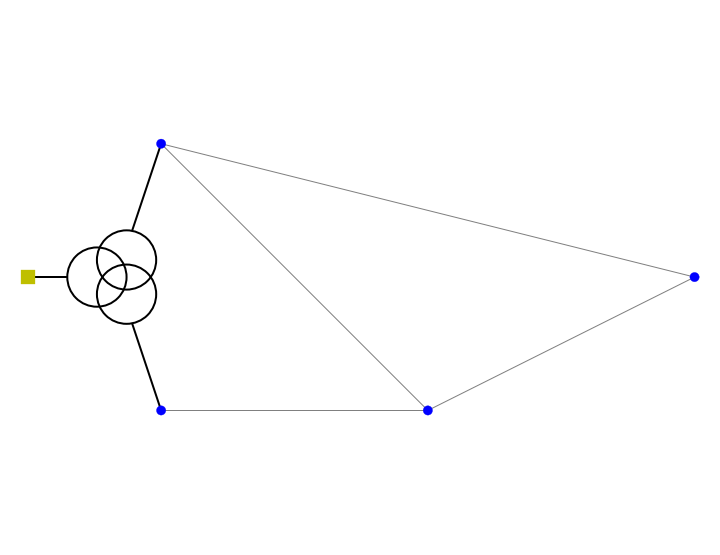

In [5]:
import pandapower.plotting as plot
%matplotlib inline
plot.simple_plot(net)

Now lets run an OPF through PowerModels and look at the results:

In [21]:
pp.runpm(net)
net.res_gen

,p_kw,q_kvar,va_degree,vm_pu
0,-77074.609662,29200.527430,-0.612243,1.001362
1,-43159.488045,-37572.504044,-1.083244,1.036136


In [22]:
net.res_ext_grid

,p_kw,q_kvar
0,-20919.713801,11484.955549


In [23]:
net.res_trafo3w

,p_hv_kw,q_hv_kvar,p_mv_kw,q_mv_kvar,p_lv_kw,q_lv_kvar,pl_kw,ql_kvar,i_hv_ka,i_mv_ka,i_lv_ka,loading_percent
0,20919.713801,-11484.955596,-24969.104329,733.822972,4217.247668,12085.470386,167.85714,1334.337762,0.062629,0.129833,0.065695,49.472885


In [24]:
net.res_line

,p_from_kw,q_from_kvar,p_to_kw,q_to_kvar,pl_kw,ql_kvar,i_from_ka,i_to_ka,i_ka,loading_percent
0,-10686.111585,7740.274011,10899.499076,-9643.812579,213.387491,-1903.538568,0.068580,0.076282,0.076282,16.230171
1,-3824.889414,-19556.714835,4116.839061,18447.191799,291.949647,-1109.523036,0.104449,0.095745,0.104449,22.223119
2,24755.722470,7950.005733,-24344.784086,-8474.096983,410.938384,-524.091251,0.131710,0.133978,0.133978,28.505995
3,4286.926514,11175.306486,-4217.247668,-12085.470386,69.678846,-910.163899,0.060632,0.065695,0.065695,13.977631


Lets set some constraints for the 3W-transformer and the lines and rerun the OPF:

In [25]:
net.trafo3w["max_loading_percent"] = 50
net.line["max_loading_percent"] = 30
pp.runpm(net)

In [26]:
net.res_trafo3w

,p_hv_kw,q_hv_kvar,p_mv_kw,q_mv_kvar,p_lv_kw,q_lv_kvar,pl_kw,ql_kvar,i_hv_ka,i_mv_ka,i_lv_ka,loading_percent
0,20919.713801,-11484.955596,-24969.104329,733.822972,4217.247668,12085.470386,167.85714,1334.337762,0.062629,0.129833,0.065695,49.472885


In [27]:
net.res_line

,p_from_kw,q_from_kvar,p_to_kw,q_to_kvar,pl_kw,ql_kvar,i_from_ka,i_to_ka,i_ka,loading_percent
0,-10686.111585,7740.274011,10899.499076,-9643.812579,213.387491,-1903.538568,0.068580,0.076282,0.076282,16.230171
1,-3824.889414,-19556.714835,4116.839061,18447.191799,291.949647,-1109.523036,0.104449,0.095745,0.104449,22.223119
2,24755.722470,7950.005733,-24344.784086,-8474.096983,410.938384,-524.091251,0.131710,0.133978,0.133978,28.505995
3,4286.926514,11175.306486,-4217.247668,-12085.470386,69.678846,-910.163899,0.060632,0.065695,0.065695,13.977631


We can see that the OPF ensures compliance with the given constraints. Note that PowerModels does not have a 3W-transformer model, but since pandapower includes the equations to calculates the equivalent branches for the 3W-transformers, it is possible to optimize grids with 3W-transformers using PowerModels without any extra effort by going through the pandapower interface. The same is true for other complex transformer models, switches/breaker, extended ward equivalents etc.

## Accessing the full functionality of PowerModels.jl

By default, pandapower will run the standard AC OPF provided by PowerModels with the Ipopt solver. The julia file that is used to do that can be found in pandapower/pandapower/opf/run_powermodels.jl and looks like this:

In [28]:
"""
using PowerModels
using Ipopt
import JSON

function run_powermodels(json_path)
    pm_net = Dict()
    open(json_path, "r") do f
        dicttxt = JSON.readstring(f)  # file information to string
        pm_net=JSON.parse(dicttxt)  # parse and transform data
    end
    result = PowerModels.run_ac_opf(pm_net, Ipopt.IpoptSolver())
    return result
end
""";

Of  course PowerModels is a great modular tool that allows you to do much more than that. You might want to use a different OPF formulation, a relaxation method or a different solver. You might even want to use one of the variants of PowerModels that are being developed, such as [PowerModelsACDC.jl](https://github.com/hakanergun/PowerModelsACDC.jl) or [PowerModelsReliability.jl](https://github.com/frederikgeth/PowerModelsReliability.jl).

To do that, you can switch out the standard file with your own custom .jl file. Lets say we want to run a DC OPF instead of an AC OPF. There is a custom julia file for that in pandapower/tutorials/run_powermodels_custom.jl that looks like this:

In [29]:
"""
using PowerModels
using Ipopt
import JSON

function run_powermodels(json_path)
    pm_net = Dict()
    open(json_path, "r") do f
        dicttxt = JSON.readstring(f)  # file information to string
        pm_net=JSON.parse(dicttxt)  # parse and transform data
    end
    result = run_dc_opf(pm_net, IpoptSolver())
    return result
end
""";

We point the runpm function to this file, and as we can see by the flat voltage values, the OPF is now run with a DC network formulation:

In [30]:
pp.runpm(net, julia_file="run_powermodels_custom.jl")
net.res_bus

,vm_pu,va_degree,p_kw,q_kvar,lam_p,lam_q
0,1.0,0.000000,-18658.110443,757.468700,0.0,0.0
1,1.0,-2.501254,60000.000000,0.000000,0.0,0.0
2,1.0,-0.630420,-7993.459760,5582.433820,0.0,0.0
3,1.0,-0.243770,-33406.021074,17295.179486,0.0,0.0
4,1.0,-0.699943,0.000000,0.000000,0.0,0.0


The PowerModels data structure that was passed to Julia can be accessed like this:

In [31]:
net._pm

{'gen': {'1': {'qc1max': 0.0,
   'pg': 0.0,
   'qc2max': 0.0,
   'ramp_agc': 0.0,
   'qg': 0.0,
   'gen_bus': 1,
   'ramp_10': 0.0,
   'vg': 1.0,
   'mbase': 1.0,
   'pc2': 0.0,
   'qmax': 1000000000.0,
   'gen_status': 1,
   'qmin': -1000000000.0,
   'qc1min': 0.0,
   'qc2min': 0.0,
   'pc1': 0.0,
   'ramp_q': 0.0,
   'ramp_30': 0.0,
   'pmin': -1000000.0,
   'pmax': 1000000.0,
   'apf': 0.0,
   'index': 1,
   'model': 2,
   'shutdown': 0.0,
   'startup': 0.0,
   'ncost': 1,
   'cost': [1000.0, -0.0, 0]},
  '2': {'qc1max': 0.0,
   'pg': 80.0,
   'qc2max': 0.0,
   'ramp_agc': 0.0,
   'qg': 0.0,
   'gen_bus': 3,
   'ramp_10': 0.0,
   'vg': 1.01,
   'mbase': 1.0,
   'pc2': 0.0,
   'qmax': 1000000000.0,
   'gen_status': 1,
   'qmin': -1000000000.0,
   'qc1min': 0.0,
   'qc2min': 0.0,
   'pc1': 0.0,
   'ramp_q': 0.0,
   'ramp_30': 0.0,
   'pmin': 0.0,
   'pmax': 80.0,
   'apf': 0.0,
   'index': 2,
   'model': 2,
   'shutdown': 0.0,
   'startup': 0.0,
   'ncost': 1,
   'cost': [2000.0, -0.0

There is also a callback that allows you to add additional data to the PowerModels data structure in case it is not already added by the pandapower/PowerModels interface. In the callback you can add any data from the net, ppc or any source:

In [36]:
def add_data(net, ppc, pm):
    pm["gen"]["1"]["bar"] = "foo"
    pm["f_hz"] = net.f_hz    

pp.runpm(net, pp_to_pm_callback=add_data)
print(net._pm["gen"]["1"]["bar"])
print(net._pm["f_hz"])

foo
50.0


Keep in mind that indices in PowerModels are 1-based so that the indices are shifted by one between ppc and pm. The net might contain some elements that are not in the ppc, as they are out of service or disconnected. Some notes on the internal data structure can be found in [internal_datastructure.ipynb](internal_datastructure.ipynb)